In [1]:
from datasets import load_dataset

ds = load_dataset("Wix/WixQA", "wix_kb_corpus")

In [3]:
ds["train"][0]["contents"]

'Wix Events: About the Event Details and Registration Form Pages\nGuests visiting your site view the events you offer on the Events List page. From there they can learn more on the Events Details page (if enabled) and \xa0complete the booking on the Registration Form Page.\xa0You can customize how these pages look to suit your events.Tips:\nCustomizations you make to the Events Details page and the Registration Form page (e.g. changing colors and fonts, hiding page elements) affect these page for all events. \xa0 If your site only has events without tickets, you have the option of disabling the Event Details Page.Events Details PageSite visitors who click to register for an event are first directed to the Event Details page (unless you hid the page). There, guests can receive more complete information about the event. You can customize the page to show or hide various elements, such as a map to the event location and an "About the Event" description.Events without ticketsEvents without

In [5]:
questions = load_dataset("Wix/WixQA", "wixqa_expertwritten")

In [6]:
questions["train"][0]

{'question': 'Can I start accepting payments on my site while my Wix Payments account is still under verification?',
 'answer': 'You can start accepting payments on your site using [Wix Payments](https://support.wix.com/en/article/about-wix-payments) almost immediately. However, we need to verify your identity before your account can be fully activated.',
 'article_ids': ['49d9e88fadbf11fa4e685c847590078ff9394c2fe7566094f504f53ca4aca465']}

Questions with 1 article_ids: 148 (74.00%)
Questions with 2 article_ids: 46 (23.00%)
Questions with 3 article_ids: 6 (3.00%)


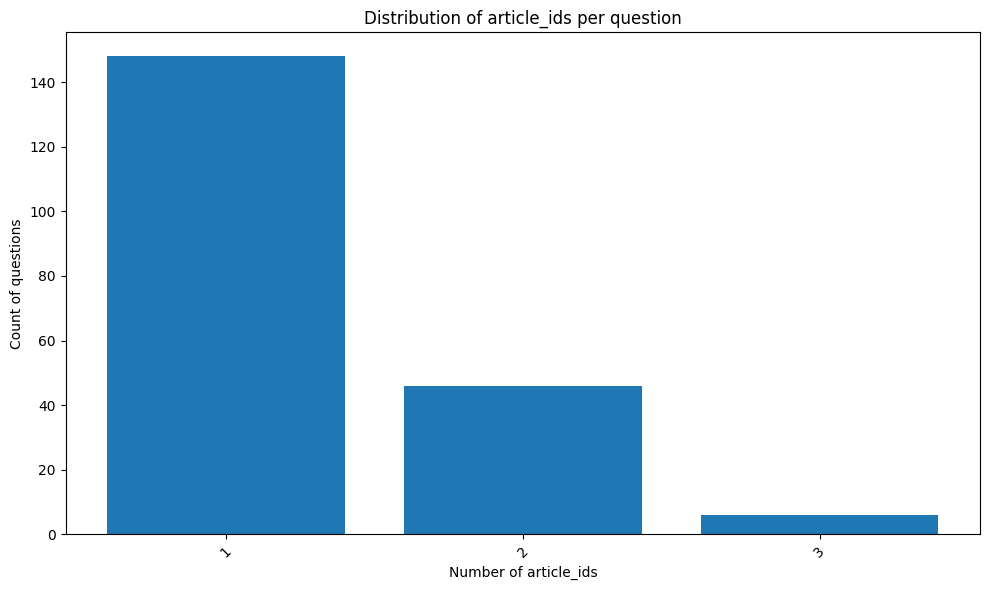

In [11]:
# Count the distribution of article_ids per question
import collections
import matplotlib.pyplot as plt

# Get the number of article_ids for each question
article_counts = [len(q["article_ids"]) for q in questions["train"]]

# Count the frequency of each number
count_distribution = collections.Counter(article_counts)

# Sort by number of article_ids
sorted_distribution = sorted(count_distribution.items())

# Print the distribution
for num_articles, count in sorted_distribution:
    print(f"Questions with {num_articles} article_ids: {count} ({count/len(article_counts)*100:.2f}%)")

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar([str(k) for k, v in sorted_distribution], [v for k, v in sorted_distribution])
plt.xlabel('Number of article_ids')
plt.ylabel('Count of questions')
plt.title('Distribution of article_ids per question')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()